1. **Install and Import Dependencies**

In [1]:
!pip install gymnasium

In [2]:
import gymnasium as gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import random
from tqdm import tqdm

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

2. **Define the Q-Network Architecture**

In [4]:
# Define model
class QNetwork(nn.Module):

    def __init__(self, state_shape, h1_nodes, action_space_size, seed):
        """ state_shape (int): Dimension of each state
            h1_nodes (int): Number of nodes in first hidden layer
            action_space_size (int): Dimension of each action
            seed (int): Random seed
        """
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_shape, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes,h1_nodes)
        self.out = nn.Linear(h1_nodes, action_space_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = self.fc1(state)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x=self.out(x)
        return x

3. **Implement the Replay Memory Class**  

In [5]:
# Define memory for Experience Replay
class ReplayMemory():
    def __init__(self, maxlen, batch_size):
        self.memory = deque([], maxlen=maxlen)
        self.batch_size = batch_size

    def append(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, self.batch_size)

    # Used in ReplayMemory class
    def sample_sequential(self):
        """Sample sequential batch for correlated experiences"""
        if len(self.memory) < self.batch_size:
            return list(self.memory)
        start_idx = random.randint(0, len(self.memory) - self.batch_size)
        return list(self.memory)[start_idx:start_idx + self.batch_size]

    def __len__(self):
        return len(self.memory)

4. **Build the Standard DQN Agent**  

In [6]:
#Define the Deep QLearning Agent
class DQAgent():
        """Interacts with and learns from the environment."""

        def __init__(self, state_shape, action_space_size, seed, h1_nodes=64, learning_rate=5e-4, replay_memory_size=int(1e5),batch_size=64, UPDATE_EVERY=1000, LEARN_EVERY=4,GAMMA=0.99):
           """Initialize an Agent object. """

           self.state_shape = state_shape
           self.action_space_size = action_space_size
           self.seed = random.seed(seed)
           self.GAMMA = GAMMA
           self.UPDATE_EVERY = UPDATE_EVERY
           self.LEARN_EVERY = LEARN_EVERY
           self.h1_nodes = h1_nodes
           self.learning_rate = learning_rate
           self.batch_size = batch_size
           self.replay_memory_size = replay_memory_size


           # Q-Network
           self.local_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)
           self.target_dqn = QNetwork(self.state_shape, self.h1_nodes, self.action_space_size, seed).to(device)

           self.optimizer = optim.Adam(self.local_dqn.parameters(), lr=self.learning_rate)

           # Replay memory
           self.memory = ReplayMemory( self.replay_memory_size,self.batch_size)

           # Initialize time step (for learn every LEARN_EVERY steps)
           self.l_step = 0

           # Initialize time step (for updating every UPDATE_EVERY steps)
           self.t_step = 0

        def state_to_dqn_input(self, state)->torch.Tensor:
           return torch.from_numpy(state).float().unsqueeze(0).to(device)

        #Returns actions for given state
        #Epsilon-greedy action selection
        def act(self, state, eps=0.):
          if random.random() > eps:
            action_values = self.local_dqn(self.state_to_dqn_input(state))
            return np.argmax(action_values.cpu().data.numpy())

          else:
            return random.choice(np.arange(self.action_space_size))

        def step(self, state, action, reward, next_state, done):
           # Save experience in replay memory
           self.memory.append((state, action, reward, next_state, done))

           # If enough samples are available in memory, get random subset and learn
           self.l_step = (self.l_step + 1) % self.LEARN_EVERY
           if self.l_step == 0 and len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

           # Copy local network to target network every UPDATE_EVERY time steps
           self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
           if self.t_step == 0:
              self.target_dqn.load_state_dict(self.local_dqn.state_dict())

        def learn(self, experiences):
          q_target_list = []
          q_expected_list = []
          # Obtain random minibatch of tuples from ReplayMemory
          for  state, action, reward, next_state, done in experiences:
             # Convert state and next_state to tensors only if they are not already tensors

             state = self.state_to_dqn_input(state)
             next_state = self.state_to_dqn_input(next_state)
             action= torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
             reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)
             ## Compute and minimize the loss

             ### Extract next maximum estimated value from target network
             if(done):
               q_target =  reward
             else:
               q_target=  reward + self.GAMMA *self.target_dqn(next_state).max(1)[0]

             ### Calculate expected value from local network
             q_local = self.local_dqn(state).gather(1, action)

             q_target_list.append(q_target)
             q_expected_list.append(q_local)

          ### Loss calculation (we used Mean squared error)
          loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()




5. **Training Function (`dqn_train`)**  

In [7]:
def dqn_train(agent, n_episodes=320, max_t=500, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon

    for i_episode in  tqdm(range(1, n_episodes+1)):
        state = env.reset()[0]

        score = 0
        for t in range(max_t):
            # select an action
            action = agent.act(state, eps)

            #apply the selected action
            next_state, reward, done, _,_=env.step(action)

            # store the current experience
            agent.step(state, action, reward, next_state, done)

            state = next_state
            score += reward
            if done:
                break

        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon

        if i_episode % 50 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

    torch.save(agent.local_dqn.state_dict(), 'checkpoint.pth')
    return scores

6. **Implement the Double DQN Agent**  

In [11]:
class DoubleDQAgent(DQAgent):
    def learn(self, experiences):

        q_target_list = []
        q_expected_list = []

        for state, action, reward, next_state, done in experiences:
            state = self.state_to_dqn_input(state)
            next_state = self.state_to_dqn_input(next_state)
            action = torch.from_numpy(np.array([action])).long().unsqueeze(0).to(device)
            reward = torch.from_numpy(np.array([reward])).float().unsqueeze(0).to(device)

            if done:
                q_target = reward
            else:
                best_action = self.local_dqn(next_state).argmax(1).unsqueeze(1)
                q_target = reward + self.GAMMA * self.target_dqn(next_state).gather(1, best_action).squeeze(0)

            q_local = self.local_dqn(state).gather(1, action)
            q_target_list.append(q_target)
            q_expected_list.append(q_local)

        loss = F.mse_loss(torch.cat(q_expected_list), torch.cat(q_target_list))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

7. **Implement DQN without Replay Memory**  

In [12]:
class DQAgentNoReplay(DQAgent):

    def __init__(self, state_shape, action_space_size, seed, h1_nodes=64,
                 learning_rate=5e-4, UPDATE_EVERY=1000, GAMMA=0.99):
        # batch_size here is not useed
        super().__init__(state_shape, action_space_size, seed, h1_nodes,
                        learning_rate, replay_memory_size=1, batch_size=1,
                        UPDATE_EVERY=UPDATE_EVERY, LEARN_EVERY=1, GAMMA=GAMMA)

    def step(self, state, action, reward, next_state, done):
        self.learn([(state, action, reward, next_state, done)])

        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            self.target_dqn.load_state_dict(self.local_dqn.state_dict())

8. **Implement DQN with Correlated Sampling**  

In [13]:
class DQAgentCorrelated(DQAgent):
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.append((state, action, reward, next_state, done))

        self.l_step = (self.l_step + 1) % self.LEARN_EVERY
        if self.l_step == 0 and len(self.memory) > self.batch_size:
            # sample_sequential() instead of sample()
            experiences = self.memory.sample_sequential()
            self.learn(experiences)

        self.t_step = (self.t_step + 1) % self.UPDATE_EVERY
        if self.t_step == 0:
            self.target_dqn.load_state_dict(self.local_dqn.state_dict())

9. **Train and Compare All Agents**  

In [14]:
env = gym.make('CartPole-v1')
print('State shape:', env.observation_space.shape[0])
print('Number of actions:', env.action_space.n)

# Dictionary to store results
results = {}


# 1. Train Standard DQN
agent_standard = DQAgent(state_shape=env.observation_space.shape[0],
                        action_space_size=env.action_space.n, seed=0)
results['Standard DQN'] = dqn_train(agent_standard)

# 2. Train Double DQN (Exercise 1)
agent_ddqn = DoubleDQAgent(state_shape=env.observation_space.shape[0],
                          action_space_size=env.action_space.n, seed=0)
results['Double DQN'] = dqn_train(agent_ddqn)

# 3. Train No Replay DQN (Exercise 2a)
agent_no_replay = DQAgentNoReplay(state_shape=env.observation_space.shape[0],
                                  action_space_size=env.action_space.n, seed=0)
results['No Replay'] = dqn_train(agent_no_replay)

# 4. Train Correlated DQN (Exercise 2b)
agent_correlated = DQAgentCorrelated(state_shape=env.observation_space.shape[0],
                                    action_space_size=env.action_space.n, seed=0)
results['Correlated'] = dqn_train(agent_correlated)



State shape: 4
Number of actions: 2


 16%|█▌        | 50/320 [00:21<01:21,  3.32it/s]

Episode 50	Average Score: 19.66


 31%|███▏      | 100/320 [00:38<01:08,  3.22it/s]

Episode 100	Average Score: 17.82


 47%|████▋     | 150/320 [00:56<00:59,  2.85it/s]

Episode 150	Average Score: 15.89


 62%|██████▎   | 200/320 [01:16<01:00,  1.99it/s]

Episode 200	Average Score: 16.69


 78%|███████▊  | 250/320 [01:59<01:03,  1.10it/s]

Episode 250	Average Score: 28.23


 94%|█████████▍| 300/320 [05:49<01:50,  5.51s/it]

Episode 300	Average Score: 121.49


 16%|█▌        | 50/320 [00:20<02:02,  2.21it/s]

Episode 50	Average Score: 18.00


 31%|███▏      | 100/320 [00:43<01:36,  2.28it/s]

Episode 100	Average Score: 17.83


 47%|████▋     | 150/320 [01:36<04:14,  1.50s/it]

Episode 150	Average Score: 30.15


 62%|██████▎   | 200/320 [05:53<11:41,  5.85s/it]

Episode 200	Average Score: 121.38


 78%|███████▊  | 250/320 [10:36<05:32,  4.75s/it]

Episode 250	Average Score: 208.70


 94%|█████████▍| 300/320 [16:13<02:38,  7.92s/it]

Episode 300	Average Score: 237.28


 17%|█▋        | 53/320 [00:02<00:14, 18.82it/s]

Episode 50	Average Score: 20.98


 32%|███▏      | 101/320 [00:05<00:09, 22.88it/s]

Episode 100	Average Score: 21.72


 48%|████▊     | 153/320 [00:08<00:07, 21.59it/s]

Episode 150	Average Score: 21.87


 63%|██████▎   | 201/320 [00:12<00:09, 12.25it/s]

Episode 200	Average Score: 24.24


 79%|███████▉  | 253/320 [00:16<00:03, 21.72it/s]

Episode 250	Average Score: 27.01


 94%|█████████▍| 300/320 [00:23<00:06,  3.25it/s]

Episode 300	Average Score: 39.62


 16%|█▌        | 50/320 [00:20<02:05,  2.15it/s]

Episode 50	Average Score: 20.22


 31%|███▏      | 100/320 [00:40<01:17,  2.83it/s]

Episode 100	Average Score: 19.24


 47%|████▋     | 150/320 [01:03<01:24,  2.00it/s]

Episode 150	Average Score: 19.37


 62%|██████▎   | 200/320 [01:29<00:54,  2.19it/s]

Episode 200	Average Score: 21.90


 78%|███████▊  | 250/320 [03:25<05:34,  4.78s/it]

Episode 250	Average Score: 62.81


 94%|█████████▍| 300/320 [08:12<01:59,  5.96s/it]

Episode 300	Average Score: 176.87


100%|██████████| 320/320 [09:48<00:00,  1.84s/it]


10. **Plot Performance Curves**  

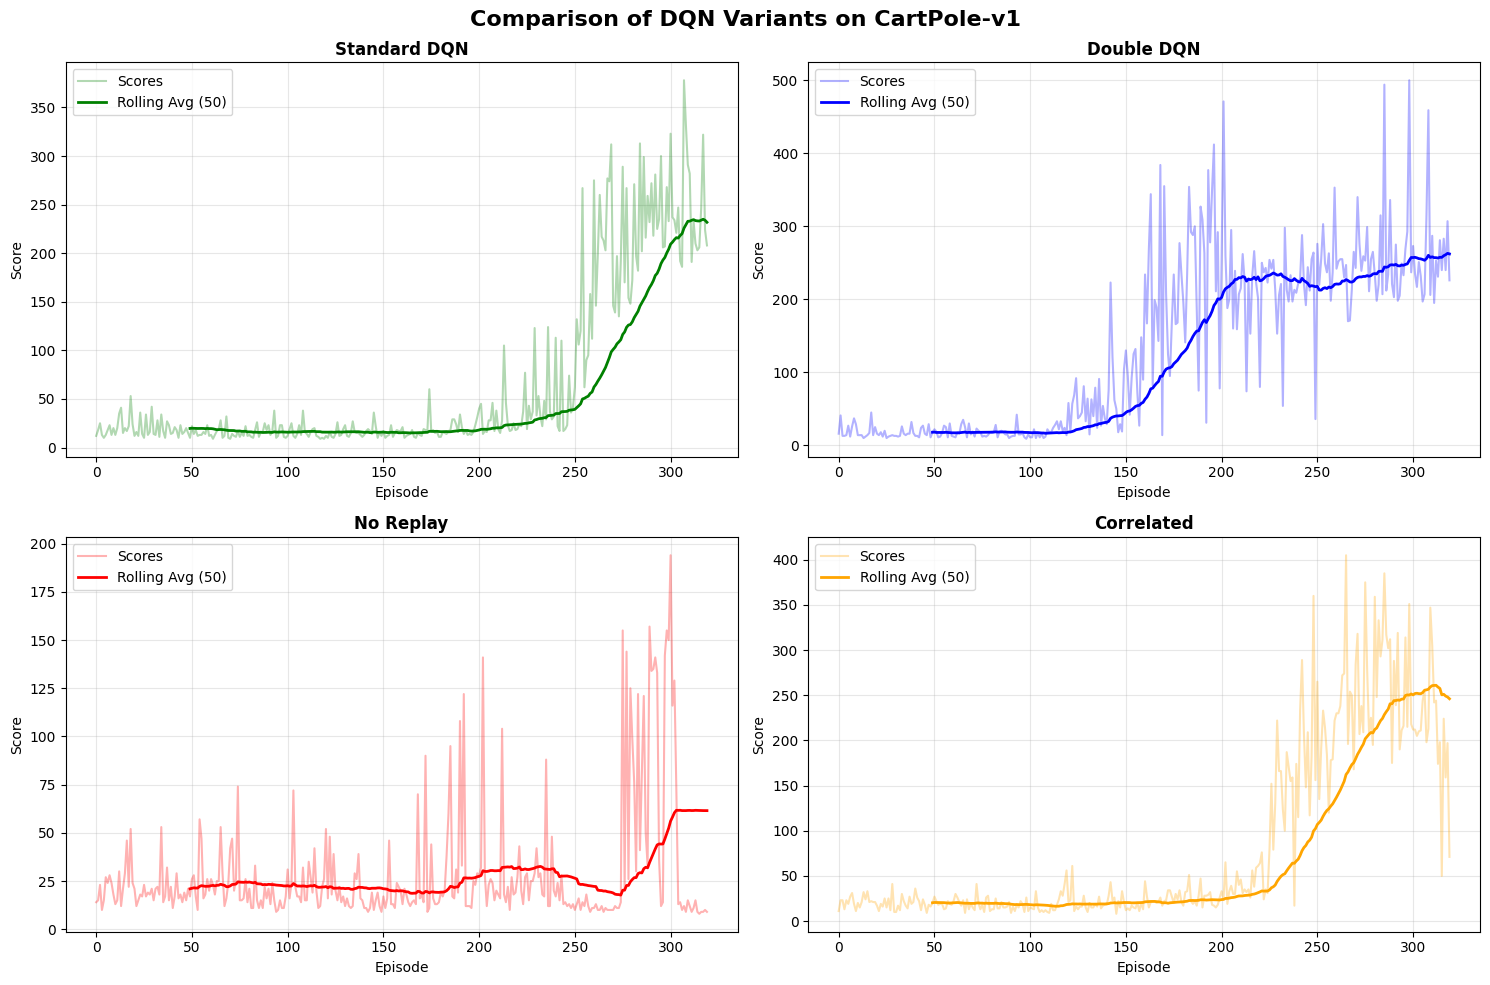

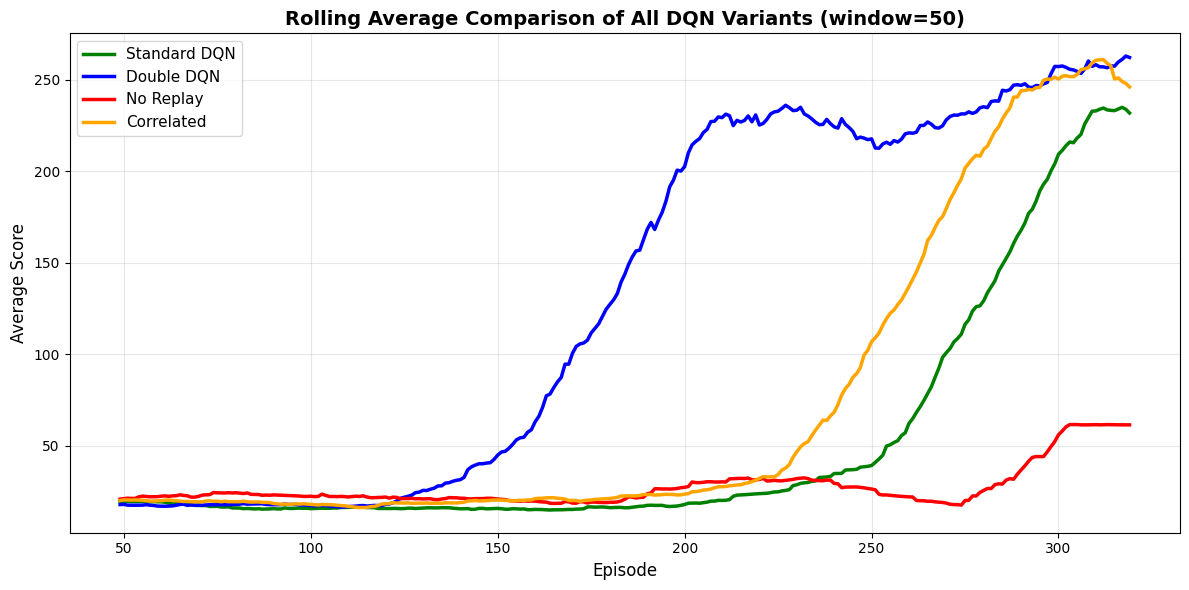


PERFORMANCE SUMMARY

Standard DQN:
  Mean Score: 64.27
  Final 100 Episodes Avg: 165.13
  Max Score: 378.00
  Min Score: 9.00
  Std Dev: 87.87

Double DQN:
  Mean Score: 133.70
  Final 100 Episodes Avg: 243.53
  Max Score: 500.00
  Min Score: 9.00
  Std Dev: 118.74

No Replay:
  Mean Score: 28.89
  Final 100 Episodes Avg: 40.33
  Max Score: 194.00
  Min Score: 8.00
  Std Dev: 31.76

Correlated:
  Mean Score: 81.16
  Final 100 Episodes Avg: 210.71
  Max Score: 405.00
  Min Score: 8.00
  Std Dev: 99.30


In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Comparison of DQN Variants on CartPole-v1', fontsize=16, fontweight='bold')

colors = {'Standard DQN': 'green', 'Double DQN': 'blue',
          'No Replay': 'red', 'Correlated': 'orange'}

# Individual plots for each agent
for idx, (name, scores) in enumerate(results.items()):
    ax = axes[idx // 2, idx % 2]
    scores_series = pd.Series(scores, name="scores")

    # Plot raw scores (transparent)
    scores_series.plot(ax=ax, label="Scores", alpha=0.3, color=colors[name])

    # Plot rolling average
    scores_series.rolling(window=50).mean().plot(
        ax=ax, label="Rolling Avg (50)", linewidth=2, color=colors[name]
    )

    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel("Episode")
    ax.set_ylabel("Score")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Combined comparison plot
fig, ax = plt.subplots(figsize=(12, 6))
for name, scores in results.items():
    scores_series = pd.Series(scores)
    scores_series.rolling(window=50).mean().plot(
        ax=ax, label=name, linewidth=2.5, color=colors[name]
    )

ax.set_title('Rolling Average Comparison of All DQN Variants (window=50)',
             fontsize=14, fontweight='bold')
ax.set_xlabel("Episode", fontsize=12)
ax.set_ylabel("Average Score", fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PERFORMANCE SUMMARY")
print("="*60)
for name, scores in results.items():
    scores_series = pd.Series(scores)
    print(f"\n{name}:")
    print(f"  Mean Score: {scores_series.mean():.2f}")
    print(f"  Final 100 Episodes Avg: {scores_series[-100:].mean():.2f}")
    print(f"  Max Score: {scores_series.max():.2f}")
    print(f"  Min Score: {scores_series.min():.2f}")
    print(f"  Std Dev: {scores_series.std():.2f}")

env.close()